# Downloading data from s3

In [1]:
import pandas as pd
from tqdm import tqdm
def load_csv_from_s3(model, checkpoint, s3):
    '''Loads .csv evals from s3 to a pandas DataFrame
    
    This function assumes that evals are stored as a group of csv file parts per model
    It also assumes that the evals are stored inside 
    s-eai-neox/memorization-evals/memorization_`model`_`checkpoint`/
    folder
    
    `model`: Name of the model
    `checkpoint`: Checkpoint of that particular model
    `s3`: Boto3 s3 client instance
    '''
    bucket_prefix = f'memorization-evals/memorization_{model}_{checkpoint}/'
    parts = s3.list_objects_v2(
        Bucket= 's-eai-neox',
        Prefix = bucket_prefix,
    )
    eval_parts = [None for i in range(len(parts['Contents']))]
    for part in tqdm(parts['Contents'], desc = f'{model}-{checkpoint}'):
        part_key = part['Key']
        rank = part_key.split('/')[-1].strip('.csv')
        index = int(rank.split('-')[-1])
        eval_parts[index] = pd.read_csv('s3://s-eai-neox/' + part_key, names=['index', 'accuracy'])
    return pd.concat(eval_parts)

In [2]:
import boto3
import os
s3 = boto3.client('s3')
res = s3.list_objects_v2(
    Bucket= 's-eai-neox',
    Prefix ='memorization-evals/',
    Delimiter = '/',
)
for model in res['CommonPrefixes']:
    _, model, checkpoint = model['Prefix'].split('/')[1].split('_')
#     if os.path.isfile(f'/fsx/orz/memorization-evals/memorization_{model}_{checkpoint}.hdf'):
#         continue
    csv = load_csv_from_s3(model, checkpoint, s3)
    csv.to_hdf(f'/fsx/orz/memorization-evals/memorization_{model}_{checkpoint}.hdf', key='memorization', index = False)

2.7b-83000:  57%|███████████████████████████████████████▉                              | 73/128 [00:42<00:32,  1.71it/s]


KeyboardInterrupt: 

# Loading data

In [28]:
models = ['19m-deduped', '125m-deduped', '350m-deduped', '800m-deduped', '1.3b-deduped', '2.7b-deduped', '6.7b-deduped', '13b-deduped']
checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
checkpoint_names = ['23m', '44m', '65m', '85m', '105m', '126m', '146m']
filepath = '/fsx/orz/memorization-evals'

In [29]:
import os
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [31]:
memorization_results = {}
for model in models:
    
    for checkpoint in tqdm(checkpoints[-1:], desc=model):
        filename = os.path.join(filepath, f'memorization_{model}_{checkpoint}.hdf')
        model_name = f'{model}-{checkpoint}'
        try:
            memorization_results[model_name] = pd.read_hdf(filename, key='memorization')
        except Exception as e:
            csv = pd.read_csv(os.path.join(filepath, f'memorization_results_{model}_{checkpoint}.csv'))
            csv.to_hdf(filename, key='memorization', index=False)
            memorization_results[model_name] = csv

19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

# Simple Multiprocess Manager

In [5]:
class MPManager:
    '''A simple class for starting multiple processes simultaneously
    
    processes: Array[multiprocess.Process] instances
    '''
    
    def __init__(self):
        self.processes = []
        
    def add(self, process):
        process.daemon=False
        self.processes.append(process)
        self.processes[-1].start()
    
    def join(self):
        for process in self.processes:
            process.join()

# Setting Params, styling

In [6]:
def update_params(size = 25):
    params = {
        'legend.fontsize': 'large',
        'figure.figsize': (15,10),
        'axes.labelsize': size,
        'axes.titlesize': size,
        'xtick.labelsize': size*0.75,
        'ytick.labelsize': size*0.75,
        'axes.titlepad': 25,
        'font.family':'sans-serif',
        'font.weight':'bold',
    }
    plt.rcParams.update(params)

# Model Accuracy Linear Regression plot

In [8]:
from itertools import cycle
import multiprocessing as mp
import scipy.stats as stats
from sklearn.metrics import r2_score

def plot_linear_regression_of_model(model, models, lock, percentile=0):
    '''Wrapper Script to plot regression lines between memorization accuracy measured and Sequence Index
    
    `model`: Name of model
    `models`: Dictionary of list of model names along with their corresponding checkpoints.
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    
    Utilizes global variable `memorization_results` to get the required evals.
    
    Plots the regression lines with confidence intervals and stores regression metrics in a csv.
    
    Metrics Stored:
        "model": Name of the model plotted
        "checkpoint": Checkpoint of the model plotted
        "most memorized percentile": `percentile` parameter of the current function
        If L(x, p) denotes the line of best fit for model p at Sequence Index x, then we store
        "slope": Defined as [L(x_max, p) - L(0, p)] / x_max
        "variation": Total variation, defined as L(x_max, p) - L(0, p)
        "% change": Percentage change induced by variation, defined as [L(x_max, p) - L(0, p)]/L(0, p)
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    update_params()
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    res = {}
    print(" ", end="", flush=True) # Bug of jupyter notebook. For more info, refer: https://github.com/tqdm/tqdm/issues/485
    bar = tqdm(
        desc=f'{model}-top {percentile} Linear Regression',
        total=len(models[model])
    )
    
    # Iterating through checkpoints
    for (model_name, evals) in memorization_results.items():
        m, checkpoint = model_name.split('-')
        if(m != model): continue
        checkpoint = int(checkpoint)
        res[checkpoint] = plot_linear_regression_of_checkpoint(model_name, evals, ax, next(cycol), 
            percentile)
        bar.update(1)
    
    # Titling and labeling plot
    fig.suptitle("Memorization Accuracy", fontsize=20)
    fig.supxlabel("Sequence Index", fontsize=20)
    fig.supylabel("Accuracy", fontsize=20)
    ax.legend(loc='lower right')
    
    # Saving plots and metrics
    fig.savefig(f'./plots/{model}-{percentile}_linear_regression.png', facecolor='white')
    lock.acquire()
    with open(f'./results/linear_regression.csv', 'a') as f:
        for checkpoint, scores in res.items():
            f.write(f'{model},{checkpoint},{percentile}')
            for score in scores:
                f.write(f',{score}')
            f.write('\n')
    bar.close()
    lock.release()
    
    
    

def plot_linear_regression_of_checkpoint(model_name, evals, axis, color, precentile = 0):
    '''Generates a linear regression plot and returns a tuple of results
    
    `model_name`: String with model and it's checkpoint
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    
    Returns:
        tuple(
            slope: slope of regression line
            variation: Total variation, defined above
            % change: percentage change induced by variation, defined above
        )
    '''
    # Top percentile evals
    top_percentile_accuracy = np.percentile(evals['accuracy'],precentile)
    top_percentile_evals = evals[evals['accuracy'] >= top_percentile_accuracy]
    
    # Actually performing regression
    indicies, accuracy = top_percentile_evals['index'], top_percentile_evals['accuracy']
    a,b = np.polyfit(indicies, accuracy,1)
    acc_best_fit = a*indicies+b
    results = (
        a, # Slope
        acc_best_fit.iloc[-1] - acc_best_fit.iloc[0], # Variation
        (acc_best_fit.iloc[-1] - acc_best_fit.iloc[0])*100/acc_best_fit.iloc[0] # % change
    )
    
    # Confidence Interval plots
    y_model = np.polyval([a, b], indicies)
    x_mean = indicies.mean()
    y_mean = accuracy.mean()
    dof = len(indicies) - 2
    t = stats.t.ppf(0.99999, dof) 
    residual = accuracy - y_model
    std_error = (np.sum(residual**2) / dof)**.5
    x_line = np.linspace(np.min(indicies), np.max(indicies), int(1e6))
    y_line = np.polyval([a, b], x_line)
    ci = t * std_error * (1/len(indicies) + (x_line - x_mean)**2 / np.sum((indicies - x_mean)**2))**.5
    
    # Actually plotting data
    axis.plot(x_line, y_line,
        color=color, label=model_name)
    axis.fill_between(x_line, (y_line-ci), (y_line+ci), color=color, alpha=0.2)
    return results

# Bucketed Memorization Plots

In [9]:
from itertools import cycle
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])

def plot_bucketed_scores_of_model(model, models, lock, percentile=0, metric='accuracy'):
    '''Wrapper Script to plot bucketed mean plots between memorization accuracy measured and Sequence Index
    
    `model`: Name of model
    `models`: Dictionary of list of model names along with their corresponding checkpoints.
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    `metric`: Could be one of accuracy or nll_loss. Using Accuracy only for now.
    
    Utilizes global variable `memorization_results` to get the required evals.
    
    Plots the bucketed memorization plots.
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    print(" ", end="", flush=True)
    bar = tqdm(
        desc=f'{model}-top {percentile} Bucketed Memorization',
        total=len(models[model])
    )
    
    # Iterating through checkpoints
    for (model_name, evals) in memorization_results.items():
        m, checkpoint = model_name.split('-')
        if(m != model): continue
        checkpoint = int(checkpoint)
        plot_bucketed_scores_of_checkpoint(
            model_name, evals, 
           ax, next(cycol), 
           percentile, 
           metric=metric
        )
        bar.update(1)
    
    # Titling and labeling plot
    fig.suptitle("Bucketed Memorization Accuracy", fontsize=20)
    fig.supxlabel("Sequence Index", fontsize=20)
    fig.supylabel("Accuracy", fontsize=20)
    ax.legend(loc='lower right')
    
    # Saving plot
    fig.savefig(f'./plots/{model}-{percentile}_bucketed_memorization.png', facecolor='white')
    bar.close()

def plot_bucketed_scores_of_checkpoint(
    model_name, evals, axis, color, 
    precentile = 0, 
    bucket_size=235520,
    metric='accuracy'
):
    '''Plots bucketed memorization scores
    
    `model_name`: String with model and it's checkpoint
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    `percentile`: Sample only Indicies with accuracy more than or equal to k percentile accuracy
    `bucket_size`: Number of samples to group into one bucket, Score of a bucket is individual scores' mean
    `metric`: Is only accuracy for now
    '''
    # Top percentile evals
    top_percentile_metric = np.percentile(evals[metric],precentile)
    top_percentile_evals = evals[evals[metric] >= top_percentile_metric]
    
    # Bucketing data and calculating errors
    indicies = []
    metric_means = []
    metric_errs = []
    for i in range(0, (len(evals)),bucket_size):
        result = top_percentile_evals[
            (i <= top_percentile_evals['index']) & 
            (top_percentile_evals['index'] < (i+bucket_size))
        ]
        if(len(result) == 0):
            continue
        indicies.append(result['index'].iloc[-1])
        metric_means.append(result[metric].mean())
        metric_errs.append(result[metric].std()/np.sqrt(len(result)))
    
    # Plotting the results
    axis.plot(indicies, metric_means, label=model_name, color=color)

# Parallelizing plot generations

In [10]:
update_params()
manager = MPManager()
lock = mp.Lock()
with open('./results/linear_regression.csv', 'w') as f:
    f.write('model,checkpoint,most memorized percentile,slope,variation,% change\n')
for model in models.keys():
    manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, models, lock, 0)))
    manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, models, lock, 90)))
    manager.add(mp.Process(target=plot_bucketed_scores_of_model, args=(model, models, lock, 99)))
    manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, models, lock, 0)))
    manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, models, lock, 99)))
    manager.add(mp.Process(target=plot_linear_regression_of_model, args=(model, models, lock, 90)))
manager.join()

13B-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

13B-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

13B-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

13B_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

6.7B-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

6.7B-top 0 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B-top 99 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

6.7B-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

6.7B-top 90 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 90 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 99 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

6.7B_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 0 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 0 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 0 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 90 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

2.7B-top 99 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 99 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 90 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 0 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 99 Linear Regression:   0%|          | 0/7 [00:02<?, ?it/s]

1.3B_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

800M-top 90 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

800M_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:01<?, ?it/s]

1.3B-top 90 Linear Regression:   0%|          | 0/7 [00:01<?, ?it/s]

800M_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

1.3B_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

800M-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

800M-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

800M-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

800M-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

800M_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

800M_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

1.3B_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

800M-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 90 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

800M_deduped-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 0 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

800M_deduped-top 99 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

350M-top 0 Linear Regression:   0%|          | 0/7 [00:00<?, ?it/s]

125M-top 90 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

125M_deduped-top 99 Bucketed Memorization:   0%|          | 0/7 [00:00<?, ?it/s]

# Normalized Signal Cross Correlation

In [11]:
import matplotlib
import scipy.signal
from itertools import cycle
from multiprocessing import Process
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])


def plot_normalized_cross_correlation_of_model(model, checkpoint, models):
    '''Wrapper Script to plot Normalized Signal Cross Correlation between two checkpoints of a model
    
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model to be correlated from
    `evals`: Evaluation results of corresponding model on corresponding checkpoint
    `axis`, `color`: Plotting params
    '''
    # Initialization and beautification
    cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
    fig = matplotlib.figure.Figure()
    ax = fig.subplots()
    print(" ", end="", flush=True)
    bar = tqdm(
        desc=f'{model}-{checkpoint} Cross Correlation',
        total=len(models[model][models[model].index(int(checkpoint)):]) - 1
    )
    one_evals = memorization_results[f'{model}-{checkpoint}']
    corr_peaks = {}
    
    # Iterating through checkpoints
    for (model_two, evals) in memorization_results.items():
        m, c = model_two.split('-')
        if(m != model): continue
        if(int(c) <= int(checkpoint)): continue
        name, peak = plot_normalized_cross_correlation(
            f'{model}-{checkpoint}', one_evals, 
            model_two, evals,
            ax, next(cycol)
        )
        corr_peaks[name] = peak
        bar.update(1)
    
    # Titling and labeling plot
    handles, labels = fig.gca().get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -corr_peaks[t[0]]))
    fig.suptitle("Memorization Accuracy Cross Correlation", fontsize=20)
    fig.supxlabel("Correlation Lags", fontsize=20)
    fig.supylabel("Discrete Linear Normalized Correlation", fontsize=20)
    ax.set_xlim(-1e5, 1e5)
    ax.legend(handles, labels, loc='lower right')
    
    # Saving plot
    fig.savefig(f'./plots/{model}-{checkpoint}_normalized_correlation.png', facecolor='white')
    bar.close()


def normalized_corr(x, y):
    '''Performs Normalized Signal Correlation, Defined as:
    $$ normalized (f * g)(\tau) = \frac{1}{N}\frac{((f-\mu_f) * (g - \mu_g))(\tau)}{\sigma_f\sigma_g} $$
    where 
        a*b(\tau) is full discrete linear cross-correlation of a and b
        
    returns Correlation and It's correlation lags
    '''
    x -= x.mean()
    y -= y.mean()
    corr = scipy.signal.correlate(x, y)
    corr /= (np.sqrt(np.sum(x**2) * np.sum(y**2)))
    corr_lags = scipy.signal.correlation_lags(len(x), len(y))
    return corr, corr_lags

def plot_normalized_cross_correlation(name_one, evals_one, name_two, evals_two, axis, color):
    '''Plots Normalized Cross Correlation
    
    `name_one`, `name_two`: Model names with checkpoints
    `eval_one`, `eval_two`: Evaluation Results
    `color`: Beautifying parameter
    '''
    # Extract Data
    model_one, checkpoint_one = name_one.split('-')
    corr_peaks = {}
    model_two, checkpoint_two = name_two.split('-')
    x = evals_one['accuracy']
    y = evals_two['accuracy'][:len(x)]
    
    # Perform correlation
    corr, corr_lags = normalized_corr(x, y)
    
    # Plotting
    plot_color = next(cycol)
    plot_label = f'{model_one}: {checkpoint_one} and {checkpoint_two}'
    axis.plot(corr_lags, corr, label = plot_label,color=plot_color)
    
    # Indicate peaks
    corr_peaks[plot_label] = np.max(corr)
    axis.plot(corr_lags[np.argmax(corr)], np.max(corr), '_', 
             markersize=32.0, markeredgewidth=2.0, color=plot_color)
    return plot_label, np.max(corr)

In [12]:
manager = MPManager()
tot_processes = 0
for model_one, checkpoints in models.items():
    for checkpoint_one in checkpoints:
        if(checkpoint_one in [143000, 71500]): continue # No models to correlate with 143000 and 71500
            # Since these are final checkpoints
        manager.add(Process(target=plot_normalized_cross_correlation_of_model, args=(model_one, 
            str(checkpoint_one), models)))
        tot_processes+=1
        if(tot_processes >= mp.cpu_count()):
            tot_processes = 0
            manager.join()
    
manager.join()

13B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

13B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

13B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

13B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

13B-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

13B-123000 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

13B_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

13B_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

13B_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

13B_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

13B_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

13B_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

6.7B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

6.7B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

6.7B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

6.7B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

6.7B-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

6.7B-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

6.7B_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

6.7B_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

6.7B_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

6.7B_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

6.7B_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

6.7B_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

2.7B-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

2.7B-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

2.7B-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

2.7B-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

2.7B-103000 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

2.7B-123000 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

1.3B-11500 Cross Correlation:   0%|          | 0/6 [00:01<?, ?it/s]

1.3B-21500 Cross Correlation:   0%|          | 0/5 [00:01<?, ?it/s]

1.3B-31500 Cross Correlation:   0%|          | 0/4 [00:01<?, ?it/s]

1.3B-41500 Cross Correlation:   0%|          | 0/3 [00:01<?, ?it/s]

1.3B-51500 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

1.3B-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

1.3B_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:01<?, ?it/s]

1.3B_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:01<?, ?it/s]

1.3B_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:01<?, ?it/s]

1.3B_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:02<?, ?it/s]

1.3B_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:01<?, ?it/s]

800M-23000 Cross Correlation:   0%|          | 0/6 [00:01<?, ?it/s]

1.3B_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

800M-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

800M-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

800M-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

800M-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

800M-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

800M_deduped-23000 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

800M_deduped-43000 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

800M_deduped-63000 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

800M_deduped-83000 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

800M_deduped-103000 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

800M_deduped-123000 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

350M-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

350M-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

350M-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

350M-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

350M-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

350M-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

350M_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

350M_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

350M_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

350M_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

350M_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

350M_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

125M-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

125M-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

125M-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

125M-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

125M-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

125M-61500 Cross Correlation:   0%|          | 0/1 [00:01<?, ?it/s]

125M_deduped-11500 Cross Correlation:   0%|          | 0/6 [00:00<?, ?it/s]

125M_deduped-21500 Cross Correlation:   0%|          | 0/5 [00:00<?, ?it/s]

125M_deduped-31500 Cross Correlation:   0%|          | 0/4 [00:00<?, ?it/s]

125M_deduped-41500 Cross Correlation:   0%|          | 0/3 [00:00<?, ?it/s]

125M_deduped-51500 Cross Correlation:   0%|          | 0/2 [00:00<?, ?it/s]

125M_deduped-61500 Cross Correlation:   0%|          | 0/1 [00:00<?, ?it/s]

# Only Hist Plot

19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

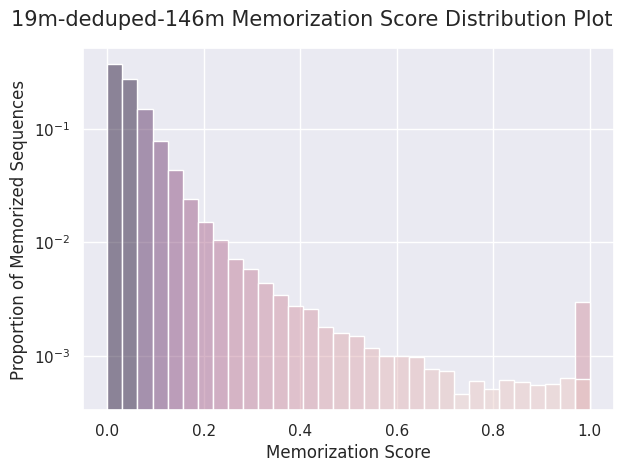

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

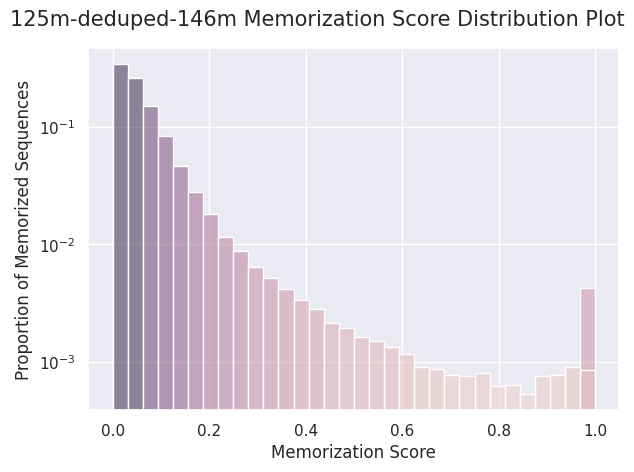

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

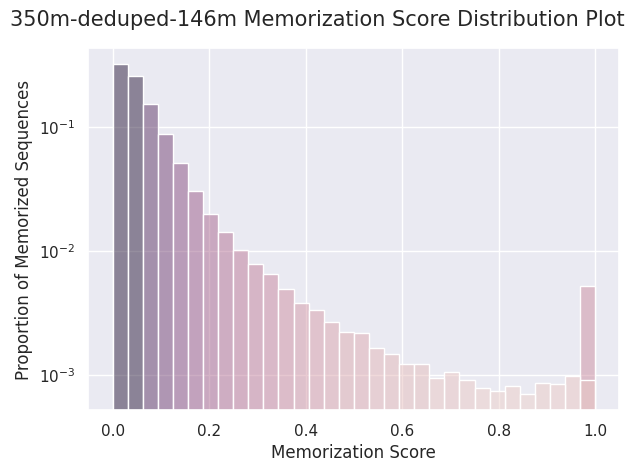

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

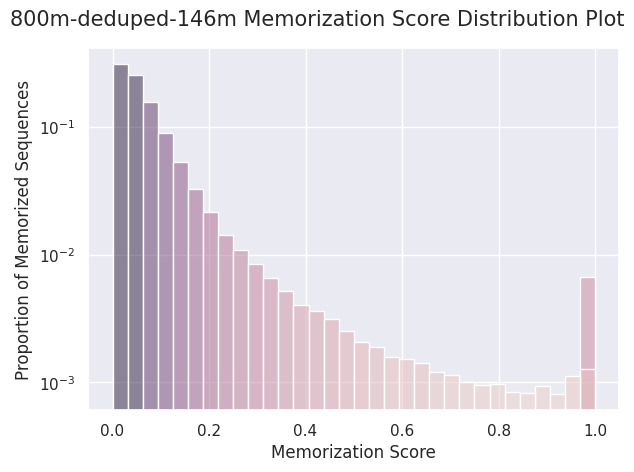

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

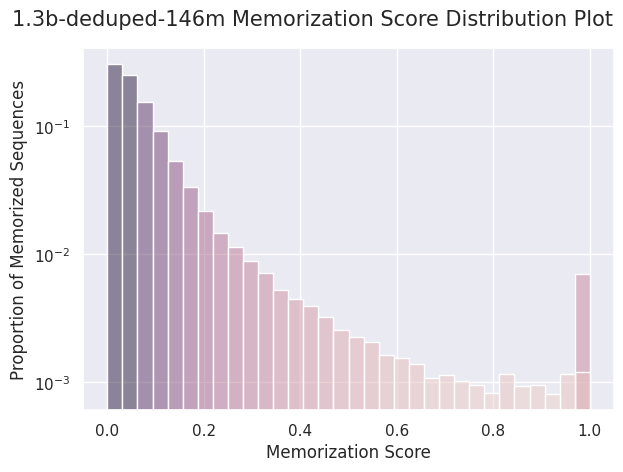

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

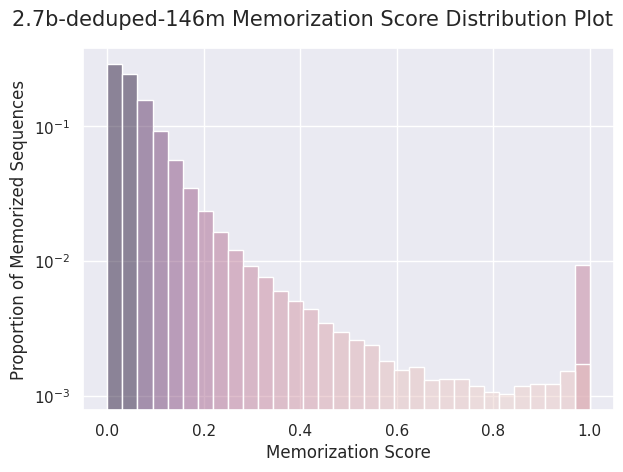

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

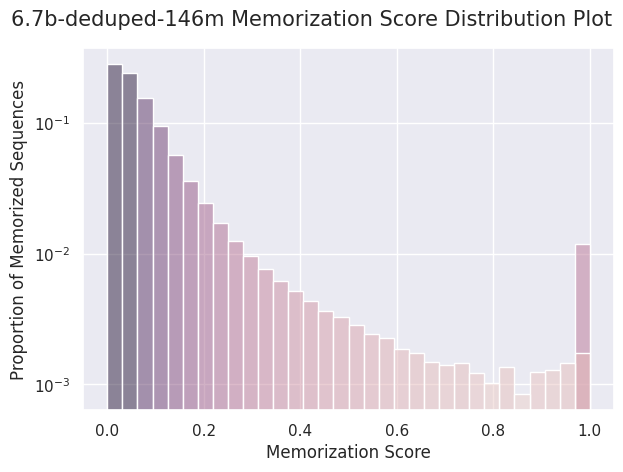

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

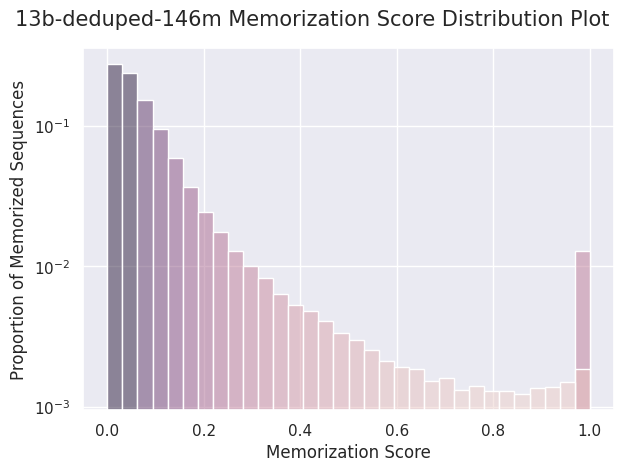

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


In [31]:
import seaborn as sns
import img2pdf
from matplotlib.colors import LogNorm

def hist_plot_of_checkpoint(model, checkpoint):
    '''Plots accuracy distribution on marginal axes and Scatter plot on joint axis
    
    Note that the colormap of scatter plot is log normalized
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model
    '''
    # Theming
    plt.clf()
    sns.set_theme(font_scale=1)
    model_name = f'{model}-{checkpoint}'
    
    # Extract Data
    evals = memorization_results[model_name].sample(frac=0.001)
    evals['Memorization Score'] = evals['accuracy']
    evals['Sequence Index'] = evals['index']
    
    # Binning
    bins = pd.cut(evals['Memorization Score'], bins=32)
    counts = evals.groupby(bins)['index'].count().reset_index()
    
    # Map binning counts to each row
    evals['acc_bin_counts'] = bins.apply(lambda x:counts[
        counts['Memorization Score'] == x]['index'].iloc[0]).astype('int32')
    
    # Calculate distribution of values
    acc_density = evals['acc_bin_counts']/evals['acc_bin_counts'].max()
    ax = sns.histplot(
        evals, 
        x = 'Memorization Score', 
        hue = acc_density.to_numpy(), 
        bins = 32, 
        legend = False, 
        stat = 'proportion',
        hue_norm = LogNorm(),
    )
    ax.set_yscale('log')

    # Labeling figure
    ax.set_ylabel("Proportion of Memorized Sequences")
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    model_name = f'{model}-{checkpoint}'
    fig  = ax.get_figure()
    fig.suptitle(f"{model_name} Memorization Score Distribution Plot", fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.savefig(f"./plots/tmp.png")
    plt.show()
    with open(f"./plots/memorization_dist_deduped_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))

for model in models:
    for checkpoint in tqdm(checkpoints[-1:], desc = model):
        hist_plot_of_checkpoint(model, checkpoint)

# Scatter Hist Plot

In [34]:
import seaborn as sns
from matplotlib.colors import LogNorm

def scatter_plot_of_checkpoint(model, checkpoint):
    '''Plots accuracy distribution on marginal axes and Scatter plot on joint axis
    
    Note that the colormap of scatter plot is log normalized
    `model`: Model name
    `checkpoint`: Checkpoint of the corresponding model
    '''
    # Theming
    plt.clf()
    sns.set_theme(font_scale=1)
    model_name = f'{model}-{checkpoint}'
    
    # Extract Data
    evals = memorization_results[model_name].sample(frac=0.001)
    evals['Memorization Score'] = evals['accuracy']
    evals['Sequence Index'] = evals['index']
    
    # Binning
    bins = pd.cut(evals['Memorization Score'], bins=32)
    counts = evals.groupby(bins)['index'].count().reset_index()
    
    # Map binning counts to each row
    evals['acc_bin_counts'] = bins.apply(lambda x:counts[
        counts['Memorization Score'] == x]['index'].iloc[0]).astype('int32')
    
    # Calculate distribution of values
    acc_density = evals['acc_bin_counts']/evals['acc_bin_counts'].max()
    
    # Plotting
    grid = sns.JointGrid(
        data = evals, 
        x = 'Sequence Index', 
        y = 'Memorization Score', 
        height = 8,  
        space = 0, 
        marginal_ticks = True,
        hue = acc_density.to_numpy(), 
#         hue_norm = LogNorm(),
    )
    
    # Scatter plot
    grid.plot_joint(
        sns.scatterplot,
        legend=False
    )
    
    # Histograms
    grid.plot_marginals(sns.histplot, fill=True, alpha=1, stat='probability', bins=32)
    
    # Labeling figure
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    model_name = f'{model}-{checkpoint}'
    fig  = grid.figure
    fig.suptitle(f"{model_name} Scatter and Hist Plot", fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig(f"./plots/tmp.png")
    with open(f"./plots/scatter_hist_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
    

13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


<Figure size 3200x3200 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

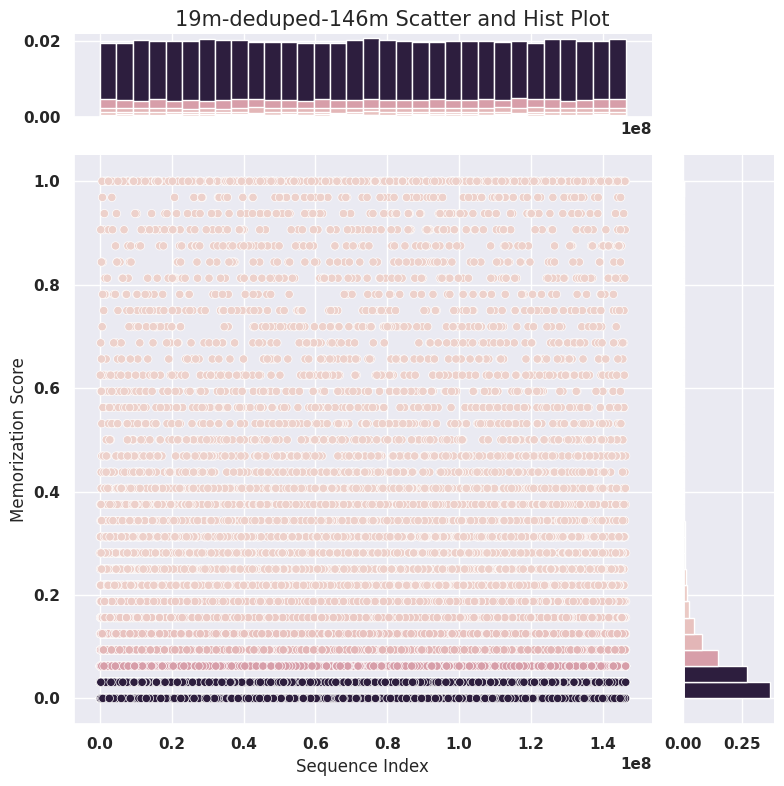

In [35]:
import multiprocessing as mp
from multiprocessing import Process, Lock
manager = MPManager()
lock = Lock()
for model in models:
    for checkpoint in tqdm(checkpoints[-1:], desc = model):
#         manager.add(Process(target=scatter_plot_of_checkpoint, args=(model, 
#             checkpoint)))
        scatter_plot_of_checkpoint(model, checkpoint)

# Model correlation plots

19m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

13b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


19m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

13b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


19m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

13b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


19m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

13b-deduped:   0%|          | 0/8 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


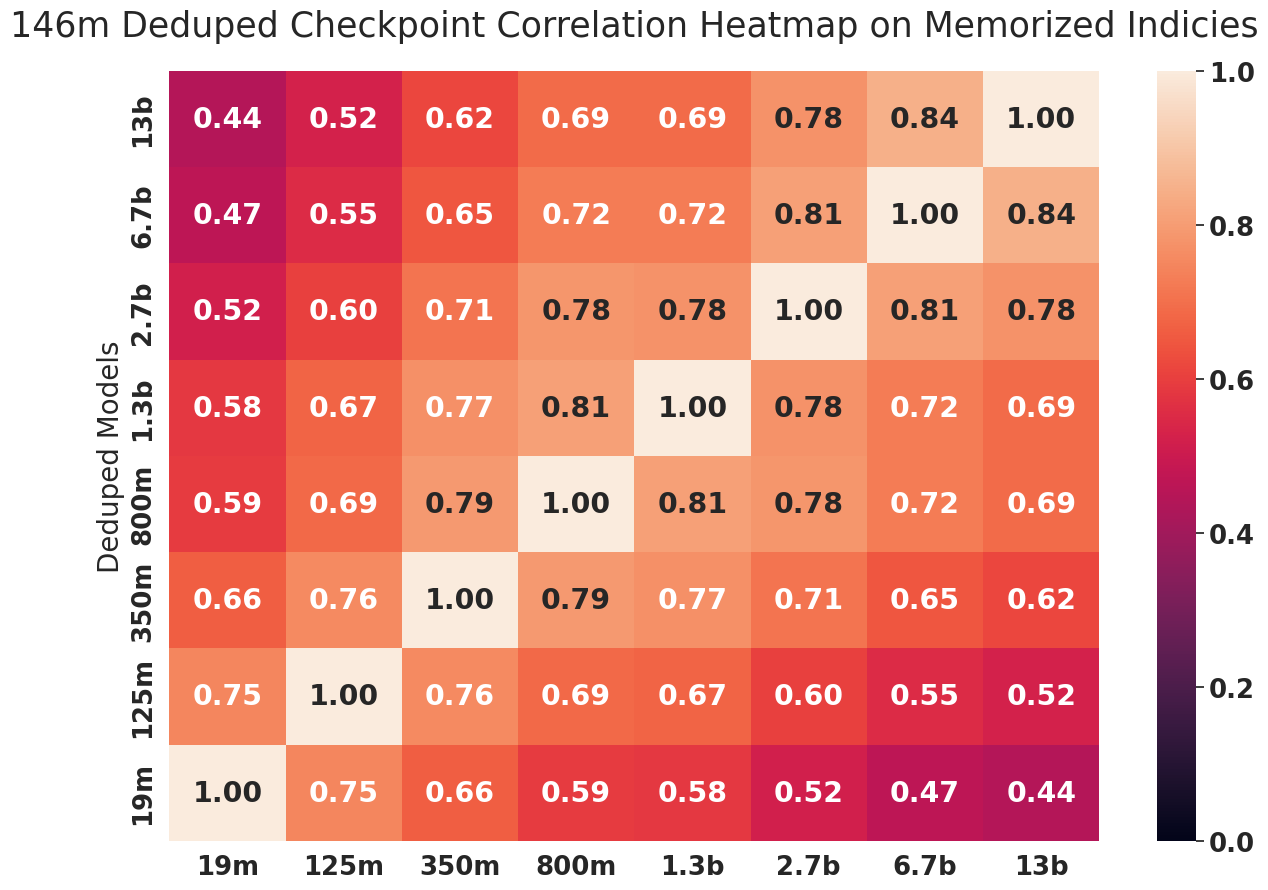

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import img2pdf
import numpy as np

def correlation_heatmap_of_models(percentile=0, checkpoint=143000):
    '''Plots Pearson'R correlation between models
    
    `percentile`: Most memorized data percentile
    '''
    # Theming
    plt.clf()
    plt.rcParams["figure.figsize"] = (32,32)
    sns.set_theme(font_scale=1.7)
    
    
    # We will use stats.pearsonr for correlation calculations
    df = {}
    for model in models:
        df[model] = memorization_results[f'{model}-{checkpoint}']['accuracy']
    
    # Extract top percentile evals if specified
    for model in models:
        if percentile > 0 and percentile != 1:
            top_percentile_acc = np.nanpercentile(df[f'{model}'],percentile)
            df[f'{model}'] = df[f'{model}'] >= top_percentile_acc
            df[f'{model}'] = df[f'{model}'].astype('float32').to_numpy()
        elif percentile == 1:
            df[f'{model}'] = df[f'{model}'] == 1
            df[f'{model}'] = df[f'{model}'].astype('float32')
    
    model_names = [m.split('-')[0] for m in models]
    correlation = pd.DataFrame(index = model_names)
    for model_1 in models:
        corrs = []
        for model_2 in tqdm(models, desc=model_1):
            acc_1 = df[model_1]
            acc_2 = df[model_2]
            corr = stats.pearsonr(acc_1, acc_2).statistic
            corrs.append(corr)
        correlation[model_names[models.index(model_1)]] = corrs
    
    # Heatmap we add annotations to also indicate value of pearson's R
    ax = sns.heatmap(correlation, annot=True, fmt='.2f', vmin=0, vmax=1, yticklabels = model_names, xticklabels = model_names)
    ax.invert_yaxis()
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    title = f"{checkpoint} Deduped Checkpoint Correlation Heatmap"
    if percentile == 1:
        title += f" on Memorized Indicies"
    elif percentile > 0:
        title += f" on top {percentile} Indicies"
    plt.title(title, fontsize=25)
    plt.ylabel("Deduped Models", fontsize=20)
    plt.savefig('./plots/tmp.png')
    if percentile == 0:
        with open(f"./plots/model_correlation_deduped_{checkpoint}.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
    elif percentile == 1:
        with open(f"./plots/model_correlation_deduped_{checkpoint}_acc1.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
    else:
        with open(f"./plots/model_correlation_deduped_{checkpoint}_{percentile}_percentile.pdf","wb") as f:
            f.write(img2pdf.convert('./plots/tmp.png'))
update_params()
for checkpoint in checkpoints[-1:]:
    correlation_heatmap_of_models(0, checkpoint)
    correlation_heatmap_of_models(90, checkpoint)
    correlation_heatmap_of_models(99, checkpoint)
    correlation_heatmap_of_models(1, checkpoint)

# Checkpoint correlation plots

19m-23000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-43000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-63000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-83000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-103000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-123000:   0%|          | 0/7 [00:00<?, ?it/s]

19m-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


125m-23000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-43000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-63000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-83000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-103000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-123000:   0%|          | 0/7 [00:00<?, ?it/s]

125m-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


350m-23000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-43000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-63000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-83000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-103000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-123000:   0%|          | 0/7 [00:00<?, ?it/s]

350m-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


800m-23000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-43000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-63000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-83000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-103000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-123000:   0%|          | 0/7 [00:00<?, ?it/s]

800m-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.3b-23000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-43000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-63000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-83000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-103000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-123000:   0%|          | 0/7 [00:00<?, ?it/s]

1.3b-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.7b-23000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-43000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-63000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-83000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-103000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-123000:   0%|          | 0/7 [00:00<?, ?it/s]

2.7b-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.7b-23000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-43000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-63000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-83000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-103000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-123000:   0%|          | 0/7 [00:00<?, ?it/s]

6.7b-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


13b-23000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-43000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-63000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-83000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-103000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-123000:   0%|          | 0/7 [00:00<?, ?it/s]

13b-143000:   0%|          | 0/7 [00:00<?, ?it/s]

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


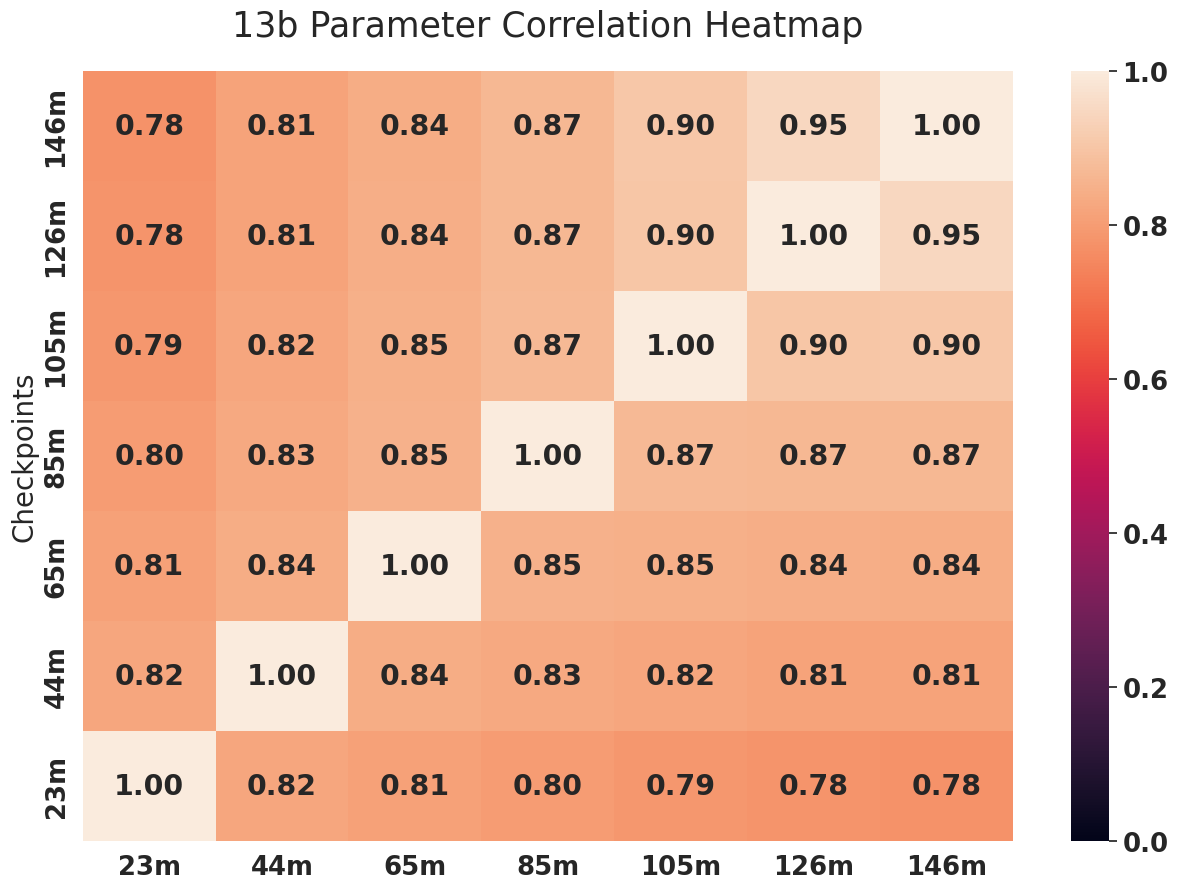

In [8]:
def plot_correlation_heatmap_of_checkpoint(model):
    '''Plots Pearson'R correlation between models
    
    `model`: Model to plot correlation of
    '''
    # Theming
    plt.clf()
    plt.rcParams["figure.figsize"] = (32,32)
    sns.set_theme(font_scale=1.7)
    
    
    # We will use stats.pearsonr for correlation calculations
    # We only consider Sequence indicies that are evaluated by all checkpoints
    max_sequence_index = 1024*23000
    df = {}
    for checkpoint in checkpoints:
        df[checkpoint] = memorization_results[f'{model}-{checkpoint}']
        df[checkpoint] = df[checkpoint][df[checkpoint]['index'] < max_sequence_index]
        df[checkpoint] = df[checkpoint]['accuracy'].to_numpy()
        
   
    # Get correlation
    correlation = pd.DataFrame(index = checkpoint_names)
    for checkpoint_1 in checkpoints:
        corrs = []
        for checkpoint_2 in tqdm(checkpoints, desc=f'{model}-{checkpoint_1}'):
            acc_1 = df[checkpoint_1]
            acc_2 = df[checkpoint_2]
            corr = stats.pearsonr(acc_1, acc_2).statistic
            corrs.append(corr)
        correlation[checkpoint_names[checkpoints.index(checkpoint_1)]] = corrs
    
    # Heatmap we add annotations to also indicate value of pearson's R
    ax = sns.heatmap(correlation, annot=True, fmt='.2f', vmin=0, vmax=1)
    ax.invert_yaxis()
    title = f"{model} Parameter Correlation Heatmap"
    plt.title(title, fontsize=25)
    plt.ylabel("Checkpoints", fontsize=20)
    plt.savefig('./plots/tmp.png')
    
    # Save plots to pdf
    with open(f"./plots/checkpoint_correlation_{model}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
update_params()
for model in models:
    plot_correlation_heatmap_of_checkpoint(model)

# KS Test & Q-Q plot: Uniformity Experiments

19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_565016/742275120.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


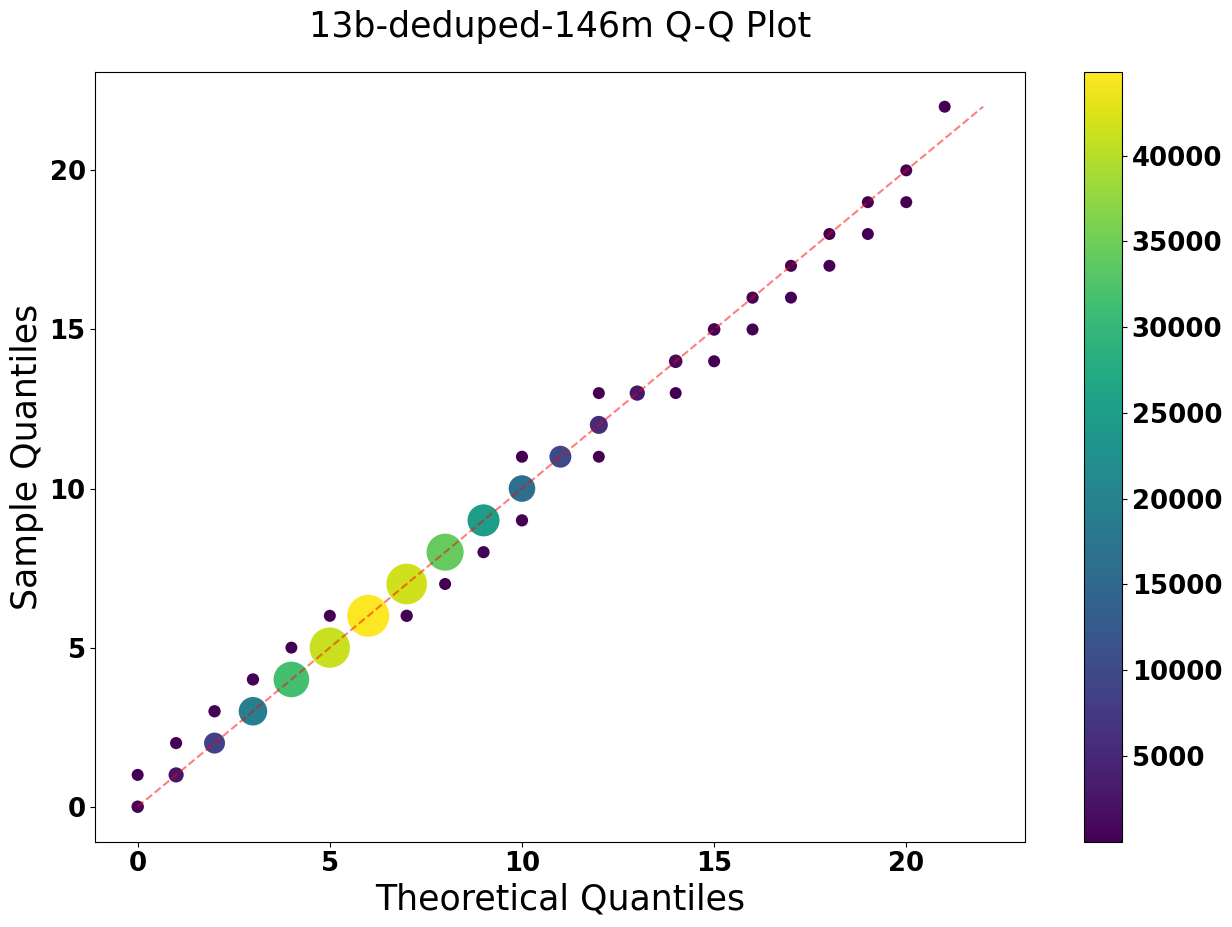

In [32]:
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as smapi
import matplotlib.pyplot as plt
import img2pdf

update_params()

def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

def qq_plot(model, checkpoint):
    '''Plots Q-Q plot of a given model's checkpoint
    
    If "fully memorized event" is defined as occurrence of a fully memorized sequence index at a given time instance,
    Where time instance for a given sequence is the index of that particular sequence within training data,
    It is observed that frequency of fully memorized events within a time-period is uniform.
    
    This statement is validated by the plotted Q-Q plots where theoretical distribution is Poisson distribution fit on 
    observed frequencies of events.
    '''
    # Clearing previous plots
    plt.clf()
    
    # Load data
    evals = memorization_results[f'{model}-{checkpoint}']
    
    # Extract fully memorized events
    evals['acc1'] = (evals['accuracy'] == 1).astype('int32')
    
    # Set batch size, also works as time unit for our temporal evaluation
    batch_size = 512
    
    # Get event frequencies, where each event is getting memorization_acc = 1
    freqs = []
    for i in range(0, checkpoint*1024, batch_size):
        num_acc_1 = evals['acc1'].iloc[i:i+batch_size].sum()
        freqs.append(num_acc_1)
    
    average_rate = np.mean(freqs)
    total_num_events = len(freqs)
        
    plotter = smapi.ProbPlot(
        np.array(freqs), 
        dist = stats.poisson(average_rate,), 
    )
    
    checkpoint = checkpoint_names[checkpoints.index(checkpoint)]
    data = pd.DataFrame()
    data['Sample Quantiles'] = plotter.sample_quantiles
    data['Theoretical Quantiles']= plotter.theoretical_quantiles
    
    dist = {}
    
    for idx, row in data.iterrows():
        x = row['Sample Quantiles']
        y = row['Theoretical Quantiles']
        if x in dist:
            if y in dist[x]:
                dist[x][y] += 1
            else:
                dist[x][y] = 1
        else:
            dist[x] = {}
            dist[x][y] = 1
    hueintensity = []
    for idx, row in data.iterrows():
        x = row['Sample Quantiles']
        y = row['Theoretical Quantiles']
        hueintensity.append(dist[x][y])
    
    norm = plt.Normalize(np.min(hueintensity), np.max(hueintensity))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    
    # Reference line
    plt.plot(
        [0, max(freqs)], [0, max(freqs)], 
        color = 'red', 
        marker = None,
        linestyle='dashed',
        alpha = 0.5
    )
    
    
    ax = sns.scatterplot(
        data, 
        x = 'Theoretical Quantiles', 
        y = 'Sample Quantiles', 
        palette = 'viridis', 
        hue = hueintensity, 
        size = hueintensity,
        sizes = (100, 1000),
        legend = False
    )
    
    ax.figure.colorbar(sm) # label = "No. Overlapping Quantiles"
    plt.title(f"{model}-{checkpoint} Q-Q Plot")
    plt.savefig("./plots/tmp.png")
    with open(f"./plots/qq_plot_{model}-{checkpoint}.pdf","wb") as f:
        f.write(img2pdf.convert('./plots/tmp.png'))
    

for model in models:
    for checkpoint in tqdm(checkpoints[-1:], desc=model):
        qq_plot(model, checkpoint)
        

In [25]:
len(memorization_results['13b-143000'][memorization_results['13b-143000']['accuracy'] == 0.03125])

34340259

In [26]:
34340259/146432000

0.2345133509069056